In [35]:
#####################################################
# Demand Forecasting-Talep Tahmini
#####################################################

# Store Item Demand Forecasting Challenge-Mağaza Ürün Talep Tahmini Zorluğu
# !pip install lightgbm
# conda install lightgbm

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings


#pd.set_option('display.max_columns', None) kodu, Pandas DataFrame'lerindeki maksimum sütun sayısını sınırlayan varsayılan sınırlamayı kaldırır. Böylece, DataFrame'in tüm sütunları gösterilir.

#pd.set_option('display.width', 500) kodu, DataFrame'in görüntülenebilecek maksimum genişliğini ayarlar. Bu kod, DataFrame'in tüm sütunlarını ekranda görüntülemek için yeterli genişlik sağlar.

#warnings.filterwarnings('ignore') kodu, Python'ın varsayılan olarak kullanılan uyarı mesajlarını devre dışı bırakır. 

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [36]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [37]:
########################
# Loading the data
########################

train = pd.read_csv('C:/Users/firengiz/PycharmProjects/pythonProject/time_series_proje/train.csv', parse_dates=['date'])
test = pd.read_csv('C:/Users/firengiz/PycharmProjects/pythonProject/time_series_proje/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('C:/Users/firengiz/PycharmProjects/pythonProject/time_series_proje/sample_submission.csv')

df = pd.concat([train, test], sort=False)


# EDA

sales NaN dEGERLERININ SEBEBI YUKARIDA TEST VE TRAIN BIRLESTIRDIK VE TEST SETINDE SALES KOLONU OMADIGI ICIN HEPSINI NAN OLARAK DONDURDU

In [38]:
df["date"].min(), df["date"].max()#ilk tarih ve son tarihe baktik

check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [39]:
df[["store"]].nunique()#10 tane essiz magaza var

store    10
dtype: int64

In [40]:
df[["item"]].nunique()#50 tane essiz urun var

item    50
dtype: int64

magaza urun kirilimdaki essiz deger sayisina bakalim yani kisaca bu essiz deger sayisi urun acisindan 50 idi ya acaba her magazada ayni 50 urun satiliyormu sonucun hepsi 50 buradan sunu anliyorum demekki butun magazlara bu 50 essiz urun gitmis

In [41]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

burada ise magaza ve urune gore satislarin sum al diyorum mesela sonucu soyle 1 ci magazada 1 ci urunden 36468 tane satilmis

In [42]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

# Satis istatistiklerinin degerlendirilmesi
yani kisaca magazalarin performansini degerlendirmis oluyoruz cesitli urunler acisinda  mesela 1 ci magazadan 1 ci urunden toplam(sum)36468 satimisiz ortalamasi 19.97,median 19 std 6.74 

In [43]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

# FEATURE ENGINEERING
burada magaza urun ay kirilimda satis istatistigi yapiyoruz groupby ile ozetle burada yaptigimiz sey mevsimsellik odaginda feature uretdik bunlar bir miktar trend bilgisinde tasyor ola bilir bir varsayimimiz var ana odagimiz bu date feature turetirken mevsimsellikleri yakalamaya yonelikti

In [44]:
def create_date_features(df):
    """bu fonksiyona date frame girildiginde baz degiskenler turetecek"""
    df['month'] = df.date.dt.month#ayi al
    df['day_of_month'] = df.date.dt.day#gunu al
    df['day_of_year'] = df.date.dt.dayofyear#yilin gunu
    df['week_of_year'] = df.date.dt.weekofyear#yilin haftasi
    df['day_of_week'] = df.date.dt.dayofweek#haftanin gun bilgisi
    df['year'] = df.date.dt.year#yil bilgisi
    df["is_wknd"] = df.date.dt.weekday // 4#hafta sonumu degilmis
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)#ayin baslangicimi 
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)#ayin sonumu
    return df

df = create_date_features(df)

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

# Random Noise
gurultu uretecek fonksiyon bu su demek oluyor ki uretecek oldugumuz gecikme featureleri bagimli degisken uzerinden uretilecek  bu uretimleri yaptigimizda asiri ogrenmenin onune gecmek icin veri setine rastgele gurultu ekliyorum 

In [45]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features
date kolonu ile mevsimselligi bir miktar yakalayabilecegimizi ve trende iliskin bazi bilgiler barindira bilecegimizi varsaydik
sonucta cikan NaN degerleriniin sebebi 1 si=hift derken kendisinden once 1 tanesini al dedigimde eee burda kendisinden once shift belirtdigi kadar sayi yyokki o yuzden NaN DEGERI TURETIYOR

In [46]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],#satislarin gercek ilk 10 degerini getir,gecikmeleri hesaplayan sey shift fonksiyonudur yani 1 sift al
              "lag1": df["sales"].shift(1).values[0:10],#1 ci gecikmeyi hesapliyorum
              "lag2": df["sales"].shift(2).values[0:10],#2
              "lag3": df["sales"].shift(3).values[0:10],#3
              "lag4": df["sales"].shift(4).values[0:10]})#4

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


LAMBDAYI KULLANARAK OTOMATIK OLARAK SHIFT YONTEMINI BURAYA UYGULAMIS OLACAGIM

In [47]:
#df.groupby(["store", "item"])['sales'].head()
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

burada yapmak istedigim sey bu farkli gecikme degerlerinde gezinsin ve bu gezme islemeleri neticesinndeki uretilecek olan yeni kolonlarda otomatik olarak dinamik olarak isimlendirilsin ve uzerine rast gele bir gurultu ekleyerek yeni kolonlar turetilsin yani yapacak oldugumuz is cesitli Lag'ler girecegiz yani arliklar.
sonucda NaN degerlerinin olmasinin sebebi:Mesela Sales_91 de Nan degerli var 91 ne demekti? 3 ay oncesiydi bunlarin hepsi aylik preiodlara gore geriye gitmis olmakta:Evet cok kritik bir bilgi neden bunu 3 aylik yaptik?Cunku ilgilendigimiz tahmin problemi 3 aylik oldugu icin.Bundan dolayi 3 aylik gerideki kolonlar ile ilgilenirsek ancak 3 ay sonrasinin degerlerini daha dogru tahmin edebilirz.Bundan dolayi olusturdugumuz kolonlari 3 ayin katlari yada 3 aya yakin olacak sekilde olusturduk .Simdi 2013-01-01  90 gun oncesinde yani 3 ay oncesinde gozlem  varmi? yok E buradn tabiiki NaN GELECEK.Sunu demek  istiyorum ki  test setine ilisikin odaklandigimizda oradaki degerlerin dolu geldigini gorecegiz nedeni ise test tarihleri ileri degerler idi dolayisiyla geriye gitdigimizde bu degerlerin dolu oldugunu gorecegiz.Agaca dayali yontem kullanacagimiz icin bu eksik degerleri rahatlikla gozardi edebilirz

In [48]:

def lag_features(dataframe, lags):
    for lag in lags:
        """bu listede gez diyourz bir suru kolon uretecek daha sonlara benim bu kolonlari takip etmem icin
        sales_leg arti hangi lag-de ise bunu strye cevirerek degisken isimi olarak ekliyorum
        lambdaa ise yukarida yaplin islemin aynisi ve uzerine rastgele gurultu ekliyor olacak"""
       

        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])#mesela 91 gunluk shift alacagiz yani 3 ay oncesine gitmis olacagiz
#91 gibi cesitli zaman periodlari girecegiz
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

# Rolling Mean Features
hareketli ortalama mesela gecmisteki 4 tane degerin ortalamasini al gibi bunnlari tahmin sonucu olarak kullan.
cikti su sekilde 13 kendisi dahil kenidisnden once 2 tane  deger barindiriyormu hayr dolayisiyla ortalamasini alamadim. 11 kendisi dahil 2 tane deger barindiriyormu evet bakin ortalamasi 12:Burada kac  adim giecegini belirleyen window argumani ifade edder:Burada cok sinsi bir problem  var-Simdi ben gecmis trendi yakalamak istiyorum Ama uretdigim kolonlarda rollingi bu sekilde kullandigimda kendisi dahil onceki 2 tane degere bakiyorum.Evet  bu problemli bir durumdur.Soyle dusunun yarinin tahminlerini elde etmeye calisiyoruz yarinin kendisi dahil gecmis 2 gozlem birimine gidip tahminde bulunma ihtimalimiz varmi?YOK cunku yarin elimizde yok.Yani kisaca bunu bir geckme alarak yapmamiz gerek 

In [49]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})


,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [50]:

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})
#harekteli ortalama turetirken mutlaka 1 b=tane shift turetmeniz gerek kisaca

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


365 rakami 1 yil onceki butun degerlerin toplaminin haraketli ortalamasi yani hani 3 aylikperiodlarda tahmin yapacaktik ya tahmin yapacak oldugumuz ilk zaman periyodunun tam 1 yil oncesinden  olusan butun degerlerinin ortalamasi ve buda yaklasik 1 bucuk yil onceki degerlerin ortalamasi bu degerlerin modele katkisi yuksek oldugundan dolayi bu degerleri sectik

In [51]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

# Exponentially Weighted Mean Features
burada farkli alfalara gore ussel agirliklari ortalamalari getirdim.Yani kisacasii en yakina en fazla agirligi ver demek.99 luk alfaya gore ussel agirlikli ortalama 11.019802 zaten 11 di bir onceki degeri neredeyse ayisi.Dolayisiyla alfa degerlerinin dusmesi ilge ne olmasini beklerim?ortalamanin 13 e dogru en azindan 12 ye dogru ilerledigini gorurum 11.947368.Yani temel mantik budur alfa degerinin dusuk olmasi daha iyi.Burada 2 oncesinemi gidicem 3 oncesinemi gidecegim problemi var.Yani burada kiyaskalmak yapmak icin 2 oncesine gitdik dolayisiyla agrilikli ortalamalar icinde belirlememiz gereken parametreler olucak

In [52]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})



,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


lags = gecikme seti bu degerleri ise ilgilendigim problemdeki mevsimsellik perioduna  yani 3 aylik perioda uygun bir sekilde olusturdum sonuc cikti:sales_ewm_alpha_05_lag_180-alfa degeri 05 gecikesi 180.Yani kisaca gecmis daha yakin degerlere agirlik veridigimizd daha basarili tahminlerde bulunur

In [53]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]#alfa seti
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

            date  store  item  sales       id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  \
44995 2018-03-27     10    50    NaN  44995.0      3            27           86            13            1  2018        0               0             0     42.314123     53.703311      66.829100      67.310252      65.504294      81.172012      79.448146      58.842771      96.730922      75.260585            88.075064            87.212755                   41.561777                   54.028375                    66.387487                    67.349358                    81.895724   
44996 2018-03-28     10 

date                               0
store                              0
item                               0
sales                          45000
id                            913000
                               ...  
sales_ewm_alpha_05_lag_180     90000
sales_ewm_alpha_05_lag_270    135000
sales_ewm_alpha_05_lag_365    182500
sales_ewm_alpha_05_lag_546    273000
sales_ewm_alpha_05_lag_728    364000
Length: 71, dtype: int64
##################### Quantiles #####################
                            0.00         0.05          0.50          0.95          0.99          1.00
store                        1.0     1.000000      5.500000     10.000000     10.000000     10.000000
item                         1.0     3.000000     25.500000     48.000000     50.000000     50.000000
sales                        0.0    16.000000     47.000000    107.000000    135.000000    231.000000
id                           0.0  2249.950000  22499.500000  42749.050000  44549.010000  44999.000000
mont

# One-Hot Encoding
var olan kategorik degerleri one hot encodingden gecirecegiz yani bu magaza 1 numaralai magaza yada degil.Magaza degerleri 1-10 kadar ve sayisal degerler bunlar bu nedenle buyukluk kucukluk tasyor.Halbuki bu magazalar arasinda buyukluk kucukluk yok.Dolayiyla bu degerleri one hot encoding den gecirip yeni bir kolonlar olusturacagiz ayni sekilde diger kolonlarida yapliacak

In [54]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

            date  sales       id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_270  \
44995 2018-03-27    NaN  44995.0            27           86            13  2018        0               0             0     42.314123     53.703311      66.829100      67.310252      65.504294      81.172012      79.448146      58.842771      96.730922      75.260585            88.075064            87.212755                   41.561777                   54.028375                    66.387487                    67.349358                    81.895724                   112.421502   
44996 2018-03-28    NaN  44996.0

date                 0
sales            45000
id              913000
day_of_month         0
day_of_year          0
                 ...  
month_8              0
month_9              0
month_10             0
month_11             0
month_12             0
Length: 146, dtype: int64
##################### Quantiles #####################
              0.00     0.05     0.50      0.95      0.99     1.00
sales          0.0    16.00     47.0    107.00    135.00    231.0
id             0.0  2249.95  22499.5  42749.05  44549.01  44999.0
day_of_month   1.0     2.00     16.0     29.00     31.00     31.0
day_of_year    1.0    16.00    174.0    347.00    362.00    366.0
week_of_year   1.0     3.00     25.0     50.00     52.00     53.0
...            ...      ...      ...       ...       ...      ...
month_8        0.0     0.00      0.0      1.00      1.00      1.0
month_9        0.0     0.00      0.0      1.00      1.00      1.0
month_10       0.0     0.00      0.0      1.00      1.00      1.0
month_1

# Converting sales to log(1+sales)
log daki 1 ifadesi normalde 0 degerinin log almak olmaz hata verir 1 ifadesi olasi bazi hatalarin onune gecer bagimli degiskeni scale etmek tamamen tercih meselesidir  iterasyon suresinin daha kisa surmesi icin tercih meselesi

In [55]:
df['sales'] = np.log1p(df["sales"].values)

check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

            date  sales       id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_270  \
44995 2018-03-27    NaN  44995.0            27           86            13  2018        0               0             0     42.314123     53.703311      66.829100      67.310252      65.504294      81.172012      79.448146      58.842771      96.730922      75.260585            88.075064            87.212755                   41.561777                   54.028375                    66.387487                    67.349358                    81.895724                   112.421502   
44996 2018-03-28    NaN  44996.0

date                 0
sales            45000
id              913000
day_of_month         0
day_of_year          0
                 ...  
month_8              0
month_9              0
month_10             0
month_11             0
month_12             0
Length: 146, dtype: int64
##################### Quantiles #####################
              0.00         0.05          0.50          0.95          0.99          1.00
sales          0.0     2.833213      3.871201      4.682131      4.912655      5.446737
id             0.0  2249.950000  22499.500000  42749.050000  44549.010000  44999.000000
day_of_month   1.0     2.000000     16.000000     29.000000     31.000000     31.000000
day_of_year    1.0    16.000000    174.000000    347.000000    362.000000    366.000000
week_of_year   1.0     3.000000     25.000000     50.000000     52.000000     53.000000
...            ...          ...           ...           ...           ...           ...
month_8        0.0     0.000000      0.000000      

# Model
# Custom Cost Function
MAE, MSE, RMSE, SSE basari metrikleri
MAE: mutlak hata demek
MAPE: ortalama mutlak yüzde hatası
SMAPE: Simetrik ortalama mutlak yüzde hatası (düzeltilmiş MAPE)

In [56]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val#bu fonksiyonu LightGBM algoirmasi ile uygulayacagiz


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()#bagimli degiskinin degerlerini ifade ediyor
    smape_val = smape(np.expm1(preds), np.expm1(labels))#gercek deger ile tahmin degerlerini kiyasliyor olucak
    return 'SMAPE', smape_val, False#SMAPE skorunu hesaplamis olucak

# Time-Based Validation Sets
zaman serisi modeli kuracagiz makina ogrenmesi modeli LightGBM yontemini kullanarak

In [57]:
train#2017-12-31 bu tarhine kadar tarin islemini yapmamiz gerekiyor

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [58]:
test#daha sonra 2018-01-01 ilk 3 ayini tahmin etmemiz bekleniyor

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [59]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.yani test
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]#bagimmsiz degiskenleri secmek

kagglenin bana veridigi validasyon  setindede 45000 satir benim olusturdugum val degiskenindede 45000 gozlem var dolaysiyla kendim model kurma surecinde kendime bir refarans noktasi olusturdum.Bunu neden yaptim cunki butun veriyi kullanarak elde edecem sonuclara guvenemiyorum bir model kurdugumda modelin gormedigi veride modelin performansini degerlendirmeye ihtiyacim var

In [60]:
Y_train = train['sales']#bagimli
X_train = train[cols]#bagimsiz

Y_val = val['sales']#bagimli 
X_val = val[cols]#bagimsiz yani y_test

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

# LightGBM ile Zaman Serisi Modeli

- >!pip install lightgbm
- >conda install lightgbm
- >metric mae: l1, absolute loss, mean_absolute_error, regression_l1
- >mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
- >rmse, root square loss, root_mean_squared_error, l2_root
- >mape, MAPE loss, mean_absolute_percentage_error

- >num_leaves: bir ağaçtaki maksimum yaprak sayısı
- >learning_rate: shrinkage_rate, eta
- >feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
- >max_depth: maksimum derinlik
- >num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

- >early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
hata düşmüyorsa modellemeyi durdur.
- >hem train süresini kısaltır hem de overfit'e engel olur.
- >nthread: num_thread, nthread, nthreads, n_jobs

In [61]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

LightGBM ozel veri yapisi lgb.Dataset(data=X_train, label=Y_train, feature_name=cols) algoru=itmayi daha hizli calistirir
feature_name=cols bagimsiz degisknlerin isimlerini ayri ifade etmek gerekir hem validasyonu hemde train yaptik
early_stopping_rounds=lgb_params['early_stopping_rounds'], belirli bir iterasyondan sonra artik validasyonda bassari metriginde ilerleme olmazsa ilerlemeyi durdur demek bu islem train suresini kisa utar ve asiri ogrenmenin karsisina gecer..Yani kisaca model karmasikliginin en optimumda birakirsak asir ogrenmenin karsisina gecer.

cikan sonuca gore: bunu anladikki hatamiz surkli dusuyor hem testde hem traindeki hata degerleri
Did not meet early stopping. Best iteration is: bu bilgi ise iterasyon sayisini 1000 yapmistik bize diyorki yani ['early_stopping_rounds'],bu
parametre calismamis cunki 200 iterasyon gitdigi hic bir senaryoda oncekine gore hatanin dusmedigi gozlemlememis hata hep dusmeye devam etmis
yani bu demek oluyorki iterasyon sayisini artirmak gerekiyor kisacasi iterasyonu 10000 den baslatmak lazim LightGBM kuvvetli bir yontem

In [62]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

#lgb.fit yerine lgb.train'de kullanilir
model = lgb.train(lgb_params, lgbtrain,#parametreleri gir,train gir,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],#iterasyon sayisi 
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,#SMAPE skorunu hesaplamis olucak basari hesplamasi
                  verbose_eval=100)#100  iterasyonda bana raporlama yap


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.459818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513744	training's SMAPE: 17.5996	valid_1's l2: 0.0533418	valid_1's SMAPE: 17.5079
[200]	training's l2: 0.0352053	training's SMAPE: 14.5675	valid_1's l2: 0.0370853	valid_1's SMAPE: 14.9071
[300]	training's l2: 0.0324293	training's SMAPE: 14.0103	valid_1's l2: 0.0341451	valid_1's SMAPE: 14.438
[400]	training's l2: 0.0313477	training's SMAPE: 13.7954	valid_1's l2: 0.0332966	valid_1's SMAPE: 14.2824
[500]	training's l2: 0.0306777	training's SMAPE: 13.6615	valid_1's l2: 0.0327152	valid_1's SMAPE: 14.1558
[600]	training's l2: 0.0302159	training's SMAPE: 13.5668	valid_1's l2: 0.0322467	valid_1's SMAPE: 14.0489
[700]	training's l2: 0.0298813	training's SMAPE: 13.498	valid_1's l2: 0.03

13.842060277794722

smape(np.expm1(y_pred_val), np.expm1(Y_val)) bu islem salesin logratimasini almistik ya bu islemde logaritmik sonuclari geriye alma islemi yani logaritma alma isleminin tersidir

In [66]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.842060277794722

# Değişken Önem Düzeyleri
trainde bir cok degiskenler uretidik madem bu degiskenleri uretdik bizim modelleme sureci gecirdik bu degiskenlerden hangisinin onemli oldugunu incelemek icin

                        feature  split       gain
17          sales_roll_mean_546    967  54.596887
13                sales_lag_364   1248  13.175517
16          sales_roll_mean_365    630   9.898131
60   sales_ewm_alpha_05_lag_365    367   4.889474
18   sales_ewm_alpha_095_lag_91     91   2.688026
..                          ...    ...        ...
111                     item_39      0   0.000000
78                       item_6      0   0.000000
115                     item_43      0   0.000000
74                       item_2      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


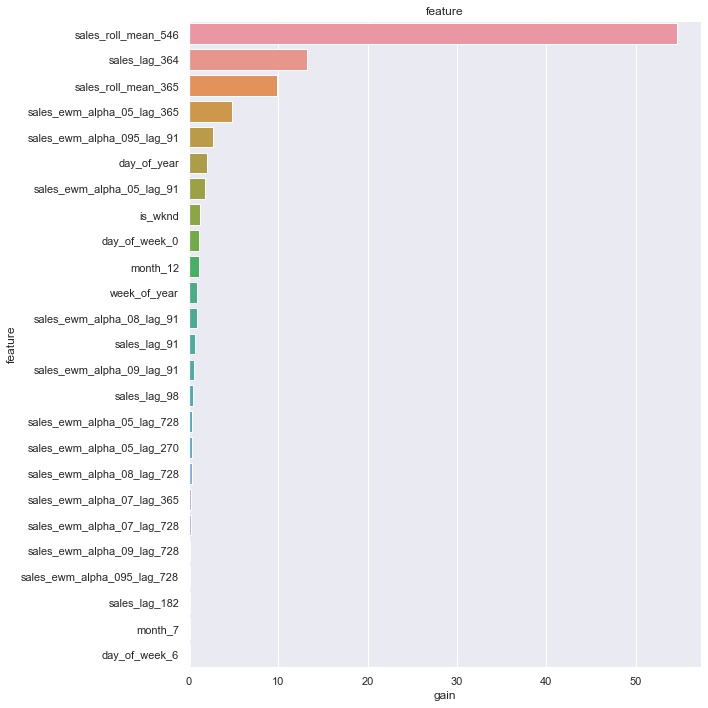

,feature,split,gain
17,sales_roll_mean_546,967,54.596887
13,sales_lag_364,1248,13.175517
16,sales_roll_mean_365,630,9.898131
60,sales_ewm_alpha_05_lag_365,367,4.889474
18,sales_ewm_alpha_095_lag_91,91,2.688026
...,...,...,...
111,item_39,0,0.000000
78,item_6,0,0.000000
115,item_43,0,0.000000
74,item_2,0,0.000000


In [70]:
def plot_lgb_importances(model, plot=False, num=10):#num kac degisken gormek istedigindir
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


In [ ]:
feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

# Final Model


In [64]:
train = df.loc[~df.sales.isna()]#df sales nan degerleri olmayanlari seciyoruz
Y_train = train['sales']#y sadece train olcak
X_train = train[cols]


test = df.loc[df.sales.isna()]#test icin ise nan degerleri olani getir yani kendi degerlerini
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}#belirledigimiz iterasyonu yaziyoruz

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.744863 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [71]:
test_preds

array([2.68395716, 2.79107967, 2.68458608, ..., 4.37471296, 4.39462033,
       4.47524198])

In [74]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,8.344121,17.027696,19.224748,15.638397,11.753473,14.978484,20.967914,14.583944,19.661547,9.783168,24.788274,25.444272,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,16.225985,18.866626,18.700587,19.315978,26.656644,20.921027,22.423130,9.693286,29.137453,9.885105,24.803898,25.765511,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,15.814917,25.936244,17.922110,11.389050,25.140038,24.187653,26.509841,17.384144,20.505463,13.106688,24.606071,20.844839,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.535964

In [73]:
# Submission File
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)

In [75]:
submission_df

,id,sales
0,0,13.642923
1,1,15.298607
2,2,13.652135
3,3,14.763048
4,4,18.476340
...,...,...
44995,44995,69.302984
44996,44996,75.289784
44997,44997,78.417041
44998,44998,80.013866
